# Business Questions
## A quantidade de quartos, banheiros, camas tem relação com a avaliação

Features

- accommodates
- bathrooms
- bedrooms
- beds

Reviews

- review_scores_rating
- review_scores_accuracy
- review_scores_cleanliness
- review_scores_checkin
- review_scores_communication
- review_scores_location
- review_scores_value


## A Vizinhança tem relação com o preço do aluguel

- neighbourhood_group_cleansed

## A Taxa de Ocupação tem relação com a  Vizinhança

# Data Understanding

## Reading Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", None)

## Reading Data

In [2]:
df_calendar = pd.read_csv('/calendar.csv', encoding= 'unicode_escape')
df_listings = pd.read_csv('/listings.csv', encoding= 'unicode_escape')
df_reviews = pd.read_csv('/reviews.csv')

## Data Verification

### Calendar

In calendar data we have price NULL when is booked

In [3]:
df_calendar.isna().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

### listings

In reviews we have 18 NULL comments but we won't use this information.

In [4]:
df_reviews.isna().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

In [5]:
colunas_missing_listings = df_listings.columns[df_listings.isna().mean() > 0].values

In [6]:
df_listings[['accommodates', 'bathrooms', 'bedrooms','beds','price', 'neighbourhood_group_cleansed']].isna().sum()

accommodates                     0
bathrooms                       16
bedrooms                         6
beds                             1
price                            0
neighbourhood_group_cleansed     0
dtype: int64

In [7]:
df_listings[['bathrooms', 'bedrooms','beds']] = df_listings[['bathrooms', 'bedrooms','beds']].apply(lambda x: x.fillna(0))
df_listings = df_listings.dropna(subset = ['price'])

In [8]:
df_listings[['accommodates', 'bathrooms', 'bedrooms','beds','price', 'neighbourhood_group_cleansed']].isna().sum()

accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
price                           0
neighbourhood_group_cleansed    0
dtype: int64

## Data Preparation

In [9]:
df_listings['id'] = df_listings['id'].astype('str').str.zfill(10).astype('str')
df_listings['price'] = df_listings['price'].str.replace('$', '', regex = True).str.replace(',','', regex = True).str.replace('.','', regex=True).astype('float')
df_listings['id'] = df_listings['id'].astype('int64')

### Creating date columns and a column that will inform if the location is booked or not

In [10]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
df_calendar['year_month'] = df_calendar['date'].dt.strftime('%Y-%m')
df_calendar['booked'] = df_calendar['available'].map({'t':0, 'f':1})


### Creating a dataframe to calculate the total booked

In [11]:
df_calendar_agg = (
    df_calendar
    .groupby('listing_id')
    .agg(
        qtd = ('listing_id', 'count'),
        total_booked = ('booked', 'sum'),
        taxa_ocupacao = ('booked', 'mean')
    )
    .reset_index()
)
df_calendar_agg['id']  = df_calendar_agg['listing_id'].astype('str').str.zfill(10).astype('str')
df_calendar_agg['id'] = df_calendar_agg['id'].astype('int64')

### Merging the calendar dataframe with listings dataframe

In [12]:
colunas = ['listing_id','qtd','total_booked','taxa_ocupacao', 'number_of_reviews', 'property_type','neighbourhood_group_cleansed', 'market','neighbourhood_cleansed', 
           'accommodates', 'bathrooms','bedrooms', 'beds', 'bed_type', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'
          ]
df_abt = pd.merge(df_listings, df_calendar_agg, left_on = 'id', right_on = 'listing_id', how = 'inner')[colunas]
df_abt.isna().sum()

listing_id                        0
qtd                               0
total_booked                      0
taxa_ocupacao                     0
number_of_reviews                 0
property_type                     1
neighbourhood_group_cleansed      0
market                            0
neighbourhood_cleansed            0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
bed_type                          0
price                             0
review_scores_rating            647
review_scores_accuracy          658
review_scores_cleanliness       653
review_scores_checkin           658
review_scores_communication     651
review_scores_location          655
review_scores_value             656
dtype: int64

### Removing rows with review scores null

In [13]:
df_abt = df_abt.dropna(subset = ['review_scores_accuracy','review_scores_checkin','review_scores_value'])
df_abt.isna().sum()

listing_id                      0
qtd                             0
total_booked                    0
taxa_ocupacao                   0
number_of_reviews               0
property_type                   0
neighbourhood_group_cleansed    0
market                          0
neighbourhood_cleansed          0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
bed_type                        0
price                           0
review_scores_rating            0
review_scores_accuracy          0
review_scores_cleanliness       0
review_scores_checkin           0
review_scores_communication     0
review_scores_location          0
review_scores_value             0
dtype: int64

### DF Final


In [14]:
numerical_features = ['accommodates', 'bathrooms', 'bedrooms','beds']

df_abt[numerical_features] = df_abt[numerical_features].astype(int)
df_abt_modeling = df_abt[['accommodates', 'bathrooms', 'bedrooms','beds','neighbourhood_cleansed', 'price']]
df_modeling_final = pd.get_dummies(df_abt_modeling, prefix = "neighbourhood_")
X = df_modeling_final.drop('price', axis = 1)
Y = df_modeling_final['price']
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state = 123, train_size= 0.7)

# Modeling 
## A Vizinhança tem relação com o preço do aluguel

#### Maior taxa de ocupação

- Cascade
     * preço médio: 11500.0

Downtown e magnolia são as vizinhanas mais caras com respectivamento 13.900 e 12.900

In [15]:
df_agg_question_1 = (
    df_abt[['neighbourhood_group_cleansed','total_booked','taxa_ocupacao', 'price', 'review_scores_location']]
    .groupby('neighbourhood_group_cleansed')
    .median()
    .reset_index()
#    .sort_values(by='total_booked', ascending = False)
    .sort_values(by='price', ascending = False)
)
df_agg_question_1

,neighbourhood_group_cleansed,total_booked,taxa_ocupacao,price,review_scores_location
9,Magnolia,8.0,0.021918,15000.0,10.0
6,Downtown,74.0,0.202740,13900.0,10.0
12,Queen Anne,86.0,0.235616,12000.0,10.0
3,Cascade,118.0,0.323288,11500.0,10.0
2,Capitol Hill,65.0,0.178082,10950.0,10.0
16,West Seattle,38.0,0.104110,10000.0,10.0
4,Central Area,62.0,0.169863,9950.0,10.0
11,Other neighborhoods,49.5,0.135616,9500.0,10.0
0,Ballard,57.0,0.156164,9500.0,10.0
14,Seward Park,29.0,0.079452,9000.0,9.0


## Taxa de Ocupação por Vizinhança

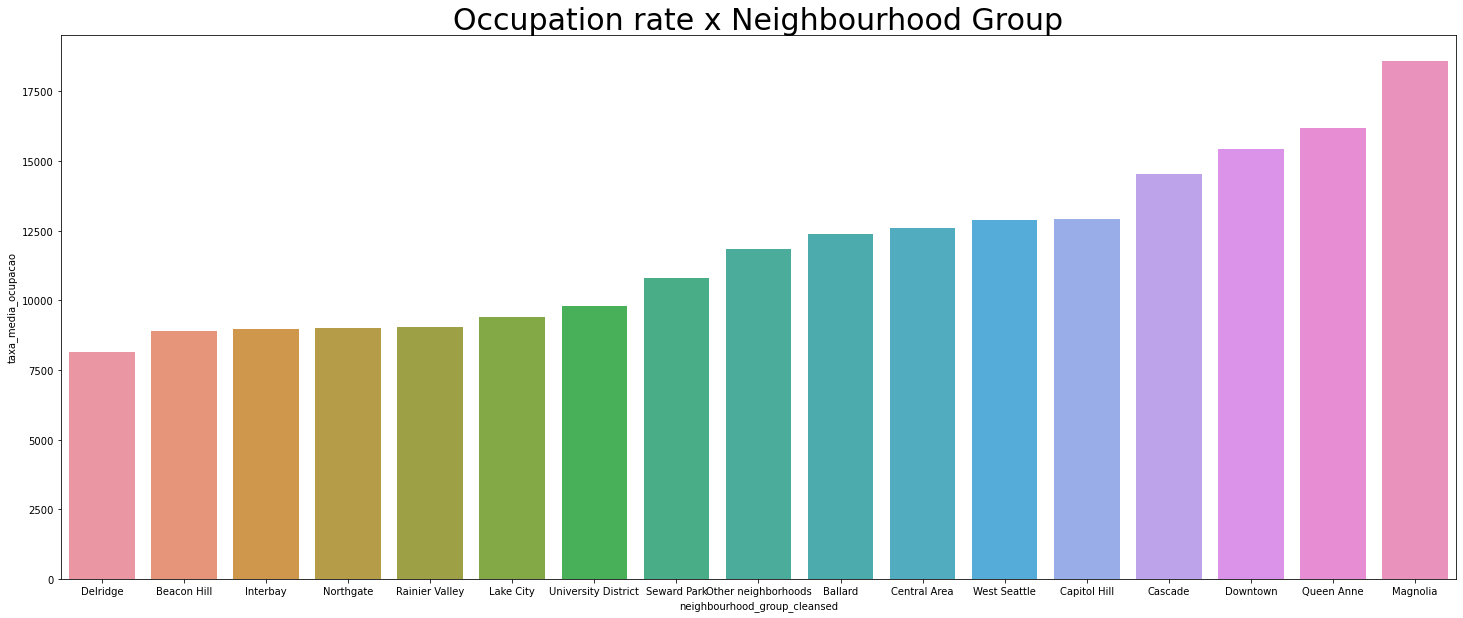

In [117]:
df_abt_agg= df_abt.groupby(['neighbourhood_group_cleansed']).agg(taxa_media_ocupacao = ('price', 'mean')).sort_values(by = 'taxa_media_ocupacao').reset_index()
plt.figure(figsize = (25,10))
plt.title("Occupation rate x Neighbourhood Group",size = 30)
sns.barplot(data = df_abt_agg, x='neighbourhood_group_cleansed', y = 'taxa_media_ocupacao')
plt.show()

## A quantidade de quartos, banheiros, camas tem relação com a avaliação

Podemos observar que conforme a quantidade de camas aumenta, maior é o preço do aluguel do imovel

### Bivariate

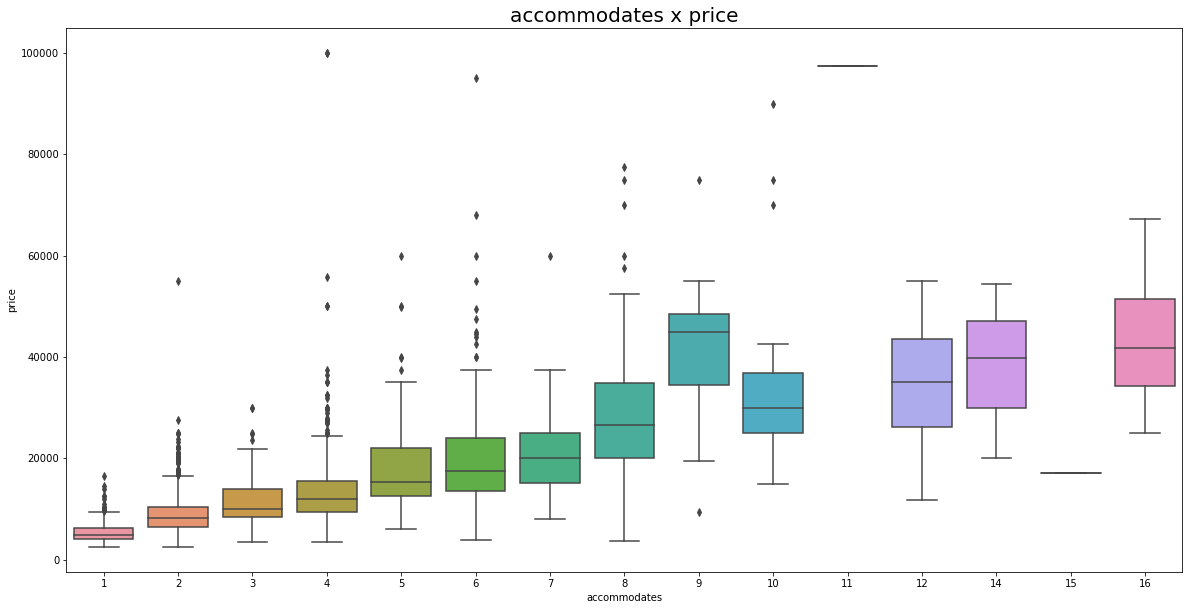

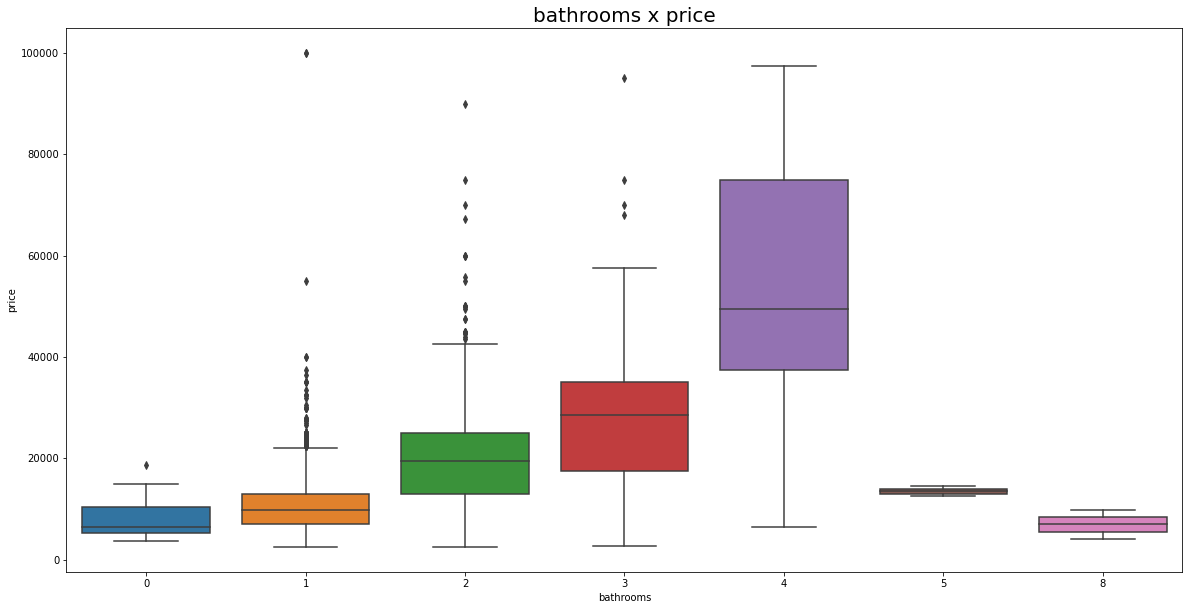

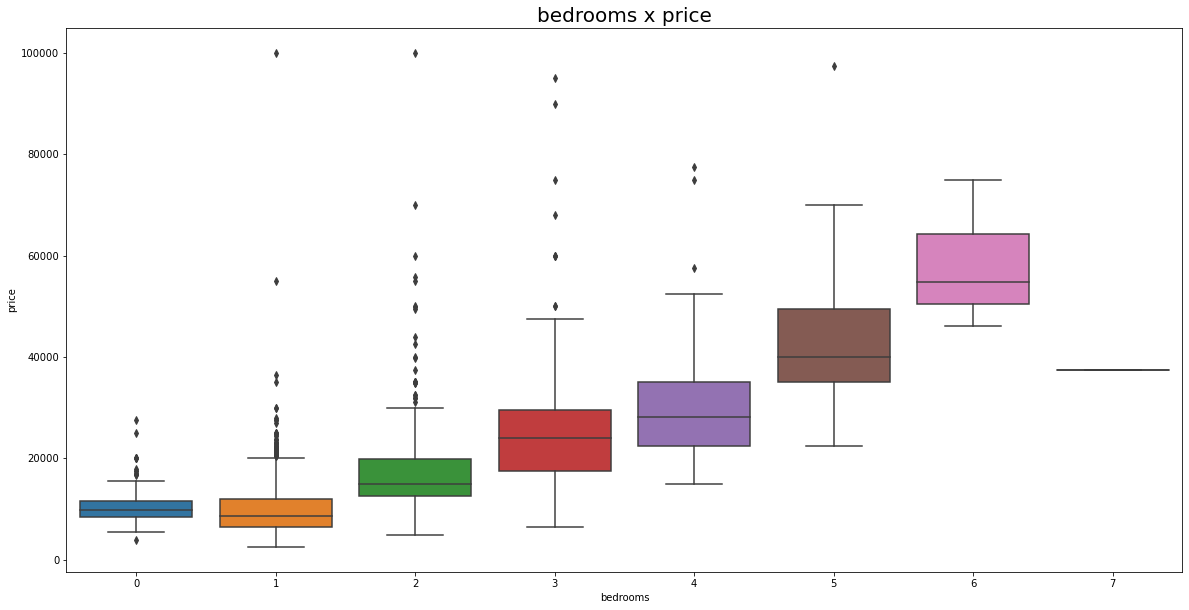

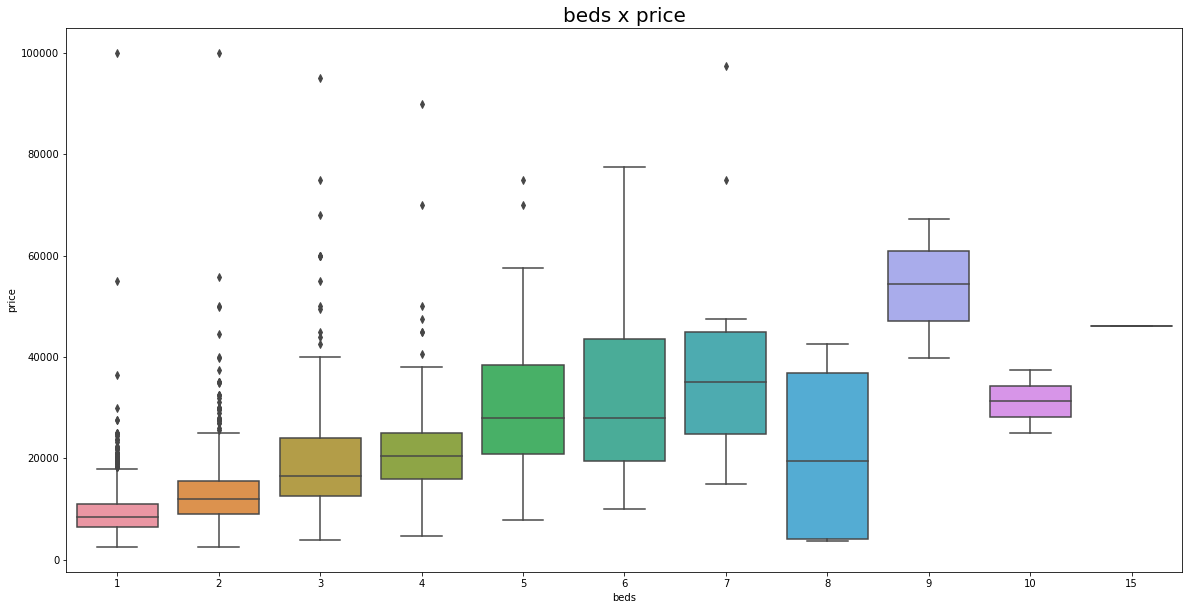

In [17]:
def PlotBoxplot(df, _x, _y):
    plt.figure(figsize = (20,10))
    plt.title(_x + " x " + _y, size = 20)
    sns.boxplot(data=df_abt, x=_x, y=_y,orient='v')
    plt.show()
    
PlotBoxplot(df_abt, 'accommodates', 'price')
PlotBoxplot(df_abt, 'bathrooms', 'price')
PlotBoxplot(df_abt, 'bedrooms', 'price')
PlotBoxplot(df_abt, 'beds', 'price')


### Univariate

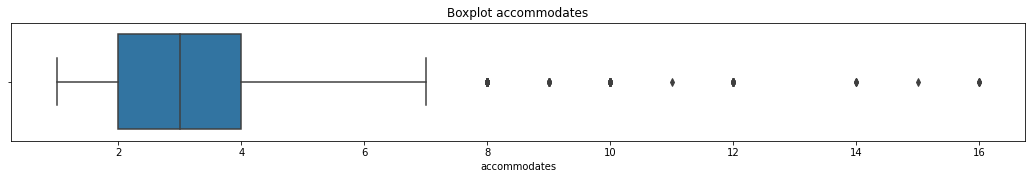

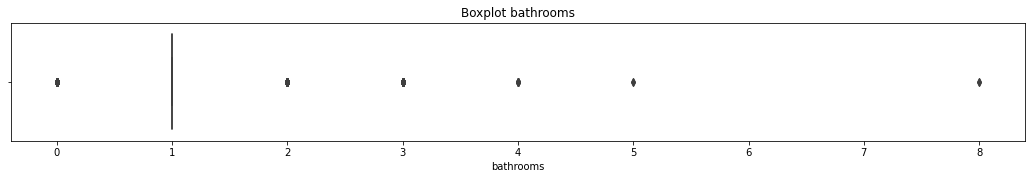

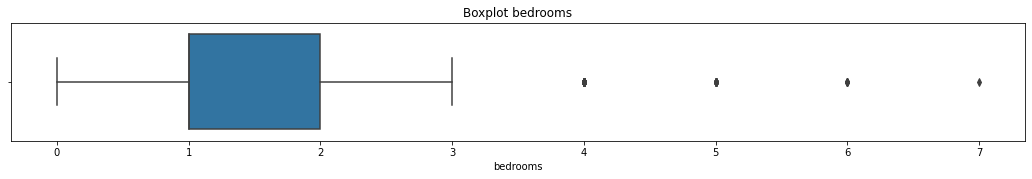

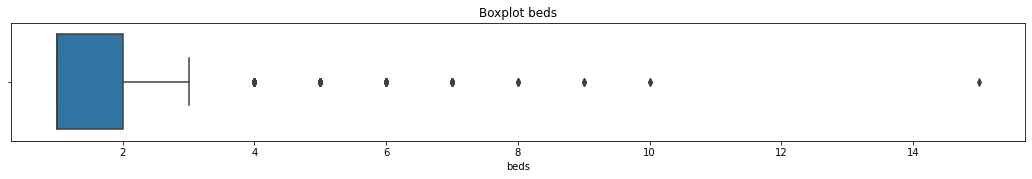

In [18]:
numerical_features = ['accommodates', 'bathrooms', 'bedrooms','beds']

for order, feature in enumerate(numerical_features):
    plt.figure(figsize = (40,10), )
    plt.subplot(4, 2, int(order) + 1)
    sns.boxplot(data = df_abt, x=feature)
    plt.title("Boxplot " + feature)
    plt.show()

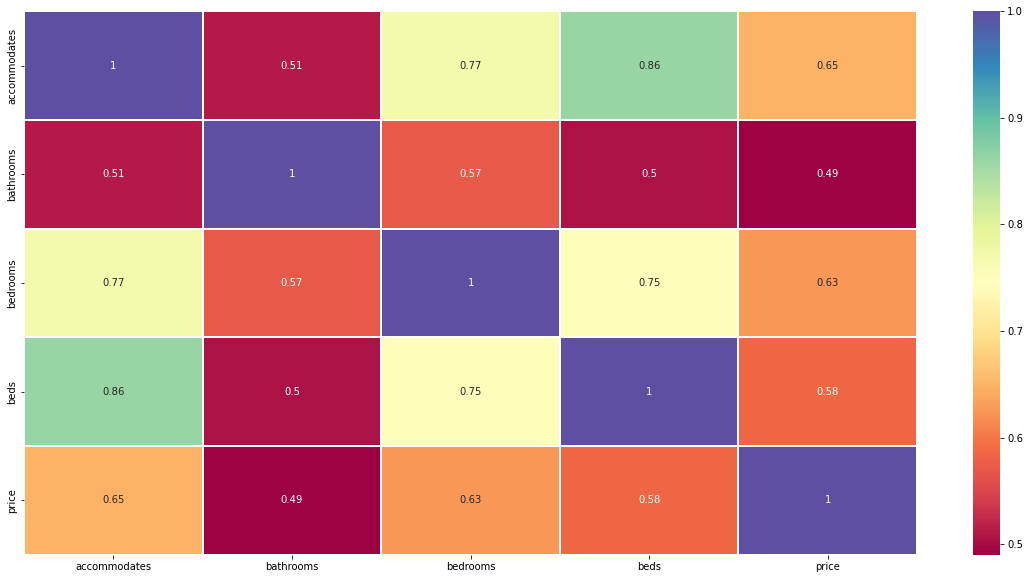

In [19]:
colunas = ['accommodates', 'bathrooms', 'bedrooms','beds','price']
plt.figure(figsize = (20,10))
sns.heatmap(df_abt[colunas].corr(), annot=True, linewidth = 1.5,cmap="Spectral")
plt.show()

In [20]:
numerical_features = ['accommodates', 'bathrooms', 'bedrooms','beds']

df_abt[numerical_features] = df_abt[numerical_features].astype(int)
df_abt_modeling = df_abt[['accommodates', 'bathrooms', 'bedrooms','beds','neighbourhood_cleansed', 'price']]
df_modeling_final = pd.get_dummies(df_abt_modeling, prefix = "neighbourhood_",)

## Fitting Model

In [21]:
lr_model = LinearRegression(normalize = True)
lr_model.fit(x_train, y_train)

LinearRegression(normalize=True)

In [22]:
import statsmodels.api as sm

X2 = sm.add_constant(x_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     31.19
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          2.58e-318
Time:                        11:35:55   Log-Likelihood:                -22301.
No. Observations:                2210   AIC:                         4.478e+04
Df Residuals:                    2120   BIC:                         4.529e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

C:\Users\thiag\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [118]:
def LinearRegressionCoefInterpretation(coef):
    if coef > 0:
        return f"The price + {coef}"
    else:
        return f"The price {coef}"

df_result = pd.DataFrame(est2.params, columns = ['coef']).reset_index()
df_result['result'] = df_result['coef'].apply(lambda x: LinearRegressionCoefInterpretation(x))
df_neighbourhood_negative = df_result[(df_result['coef'] < 0) & ( ~ df_result['index'].isin(['const', 'accommodates', 'bathrooms','bedrooms', 'beds']))].sort_values(by='coef', ascending = False).head(10)
df_neighbourhood_positive = df_result[(df_result['coef'] > 0) & ( ~ df_result['index'].isin(['const', 'accommodates', 'bathrooms','bedrooms', 'beds']))].sort_values(by='coef', ascending = False).head(10)


# Results

## Top 10 Neighbourhood that increase the price value

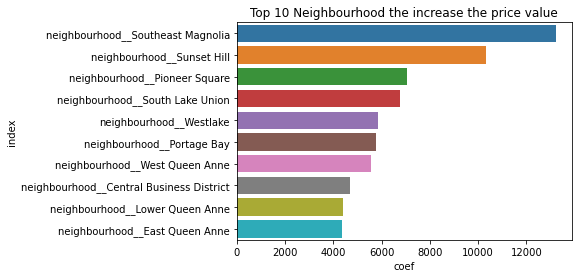

In [107]:
plt.title("Top 10 Neighbourhood that increase the price value" )
sns.barplot(data = df_neighbourhood_positive, x = 'coef', y = 'index', orient = 'h')
plt.show()

## Top 10 Neighbourhood that decrease the price value

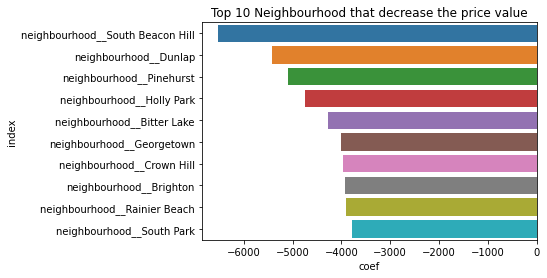

In [109]:
plt.title("Top 10 Neighbourhood that decrease the price value" )
sns.barplot(data = df_neighbourhood_negative, x = 'coef', y = 'index', orient = 'h')
plt.show()